In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [2]:
!ls

drive  sample_data


In [3]:
pwd


'/content'

In [4]:
!pip install -q keras

In [5]:
import keras
data_path = '/content/drive/My Drive/Colab Notebooks/data/WindPowerForecastingData TASK Drop 11302013.csv'

In [ ]:
import pandas as pd
# df = pd.read_csv(data_path, index_col='dattim')
df = pd.read_csv(data_path)
df.head(1)

,Unnamed: 0,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
0,0,20120101 1:00,0.0,2.1246,-2.681966,2.86428,-3.666076


In [ ]:
df.tail(1)

,Unnamed: 0,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
16775,16775,20131130 0:00,0.096232,-2.869353,1.685961,-3.871232,2.200453


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import csv
time_step = []
wind_power = []

with open( data_path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    wind_power.append(float(row[2]))
    time_step.append(row[0])

In [ ]:
import numpy as np
series = np.array(wind_power)
time = np.array(time_step)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

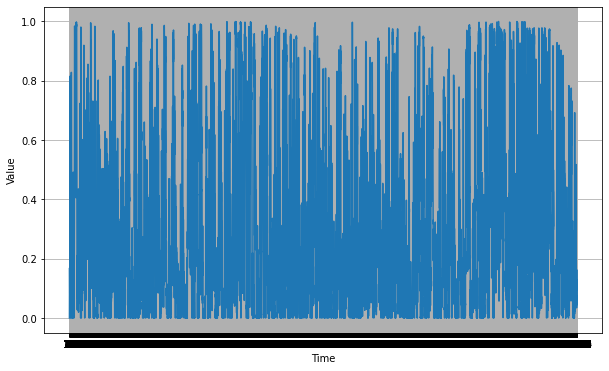

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 16608 # 01Jan2012:01 - 23Nov2013:00
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:split_time + 168] # 23Nov2013:01 - 30Nov2013:00
x_valid = series[split_time:split_time + 168]

window_size = 168
batch_size = 100
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 168
batch_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(286, return_sequences=True)),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(16608,)
Epoch 1/100
17/17 [==============================] - 3s 196ms/step - loss: 4.0212 - mae: 4.4882 - mape: 83219416.0000 - accuracy: 0.0924
Epoch 2/100
17/17 [==============================] - 4s 215ms/step - loss: 3.6039 - mae: 4.0479 - mape: 62905392.0000 - accuracy: 0.0903
Epoch 3/100
17/17 [==============================] - 4s 216ms/step - loss: 3.1646 - mae: 3.6031 - mape: 66297528.0000 - accuracy: 0.0535
Epoch 4/100
17/17 [==============================] - 4s 214ms/step - loss: 2.8306 - mae: 3.2748 - mape: 84206392.0000 - accuracy: 0.0296
Epoch 5/100
17/17 [==============================] - 4s 207ms/step - loss: 2.6033 - mae: 3.0533 - mape: 104932288.0000 - accuracy: 0.0183
Epoch 6/100
17/17 [==============================] - 3s 206ms/step - loss: 2.4521 - mae: 2.9062 - mape: 123213824.0000 - accuracy: 0.0128
Epoch 7/100
17/17 [==============================] - 4s 207ms/step - loss

(1e-08, 0.0001, 0.0, 60.0)

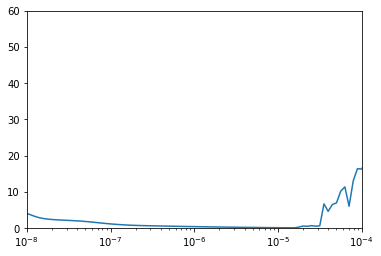

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast.shape

(16609, 168, 1)

In [ ]:
rnn_forecastx = rnn_forecast[split_time - window_size:split_time, -1, 0]

In [ ]:
rnn_forecastx.shape

(168,)

In [ ]:
split_time

16608

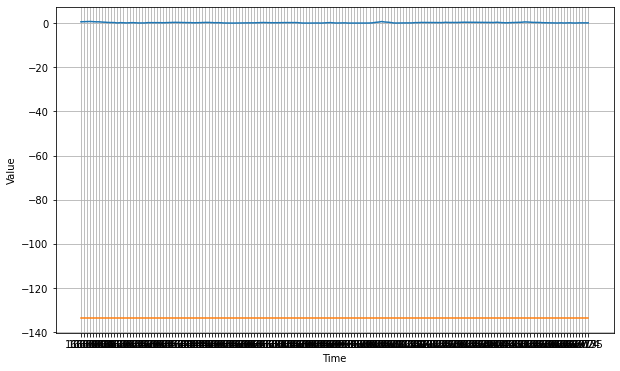

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx).numpy()

133.77708

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=672, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(286, return_sequences=True)),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(50, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
160/160 [==============================] - 19s 117ms/step - loss: 0.7587 - mae: 1.1086 - mape: 49944328.0000 - accuracy: 0.0823
Epoch 2/100
160/160 [==============================] - 18s 115ms/step - loss: 0.3002 - mae: 0.5737 - mape: 15499062.0000 - accuracy: 0.0918
Epoch 3/100
160/160 [==============================] - 19s 116ms/step - loss: 0.2230 - mae: 0.4654 - mape: 12253715.0000 - accuracy: 0.0927
Epoch 4/100
160/160 [==============================] - 19s 116ms/step - loss: 0.1796 - mae: 0.4034 - mape: 10295407.0000 - accuracy: 0.0930
Epoch 5/100
160/160 [==============================] - 18s 115ms/step - loss: 0.1513 - mae: 0.3641 - mape: 9643012.0000 - accuracy: 0.0931
Epoch 6/100
160/160 [==============================] - 19s 116ms/step - loss: 0.1301 - mae: 0.3335 - mape: 9329670.0000 - accuracy: 0.0932
Epoch 7/100
160/160 [==============================] - 19s 116ms/step - loss: 0.1127 - mae: 0.3076 - mape: 9182951.0000 - accuracy: 0.0932
Epoch 8/100
160/160 [==

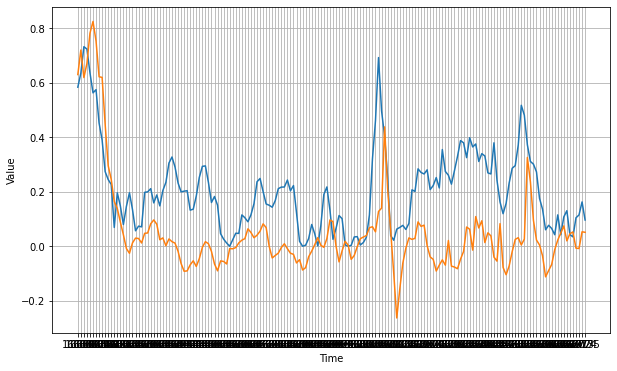

In [ ]:
rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecastx2 = rnn_forecast2[split_time - window_size-1:split_time-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx2)


In [ ]:
rnn_forecastx2.shape

(168,)

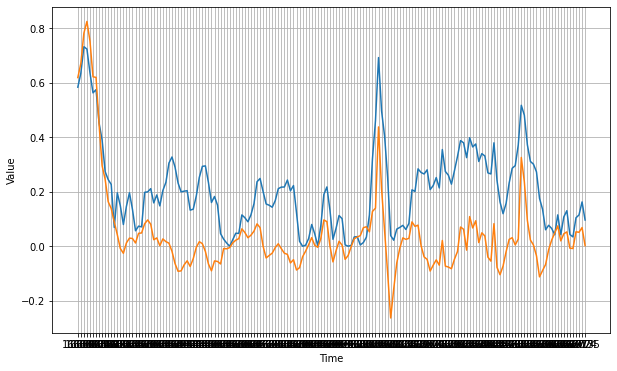

In [ ]:
#rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecastx2 = rnn_forecast2[split_time - window_size+1:split_time+1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx2)


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx2).numpy()

0.16684496